# Simulate the data acquisition of SquareLab

In [106]:
# Importing some packages
import numpy as np
import matplotlib.pyplot as mpl

## A bunch of parameters

In [111]:
time_scale = 0.1 #value in seconds
x_divisions = 12
number_of_samples = 1000

timescales = np.logspace(-7, 2, 10)
timescales = [timescales*a for a in [1, 2, 5]]
timescales = np.sort(np.reshape(timescales, 30))
print(timescales)

adc_bits = 12
y_division = 10

f_sampling = 7.2e6
fps = 30

[1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05 2.e-05 5.e-05 1.e-04
 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02 2.e-02 5.e-02 1.e-01 2.e-01
 5.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02 2.e+02 5.e+02]


## Generate test data

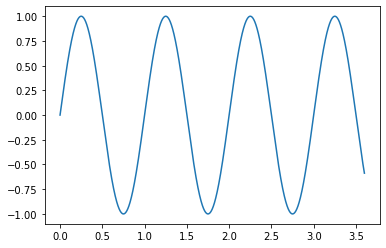

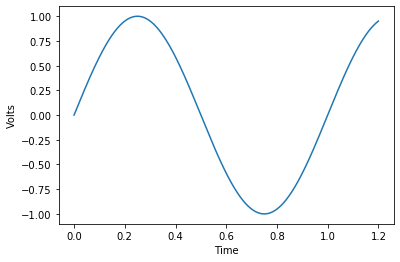

In [108]:
# Oversampling to get a smooth curve
oversample = 100
overtime = 3
sine_freq = 1
x_time = np.linspace(0, time_scale*x_divisions*overtime, number_of_samples*oversample)
# Generating sine test data
y_samples = np.sin(2*np.pi*sine_freq*x_time)

# Plotting the test data to check correctness
mpl.figure("Broader view")
mpl.plot(x_time, y_samples)
mpl.figure("Real view")
mpl.plot(x_time[0:int(number_of_samples*oversample/overtime)], y_samples[0:int(number_of_samples*oversample/overtime)])
mpl.xlabel("Time")
mpl.ylabel("Volts")
mpl.show()

## Getting measured data

1e-05


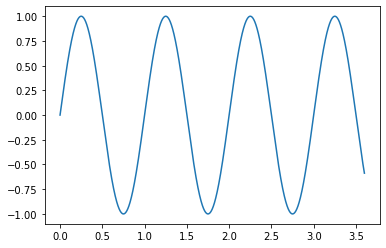

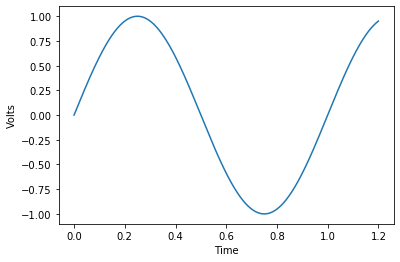

In [109]:
# Deciding if going equivalent time
# Should always get enough data to print in real time

min_timebase_equivalent = number_of_samples/(f_sampling*x_divisions)
min_timebase_equivalent = np.argmin(abs(timescales-min_timebase_equivalent))
min_timebase_equivalent = timescales[min_timebase_equivalent]
print(min_timebase_equivalent)

#Todo
# Sample in real time when timebase greater than
#Switch in equivalent time later


oversample = 100
overtime = 3
sine_freq = 1
x_time = np.linspace(0, time_scale*x_divisions*overtime, number_of_samples*oversample)
# Generating sine test data
y_samples = np.sin(2*np.pi*sine_freq*x_time)

# Plotting the test data to check correctness
mpl.figure("Broader view")
mpl.plot(x_time, y_samples)
mpl.figure("Real view")
mpl.plot(x_time[0:int(number_of_samples*oversample/overtime)], y_samples[0:int(number_of_samples*oversample/overtime)])
mpl.xlabel("Time")
mpl.ylabel("Volts")

mpl.show()